In [1]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


fs = 20000.0


In [2]:
phy_path = "/home/jovyan/work/Electrophysiology/data/ephys/2022-04-28-e-/derived/kilosort2/Trace_20220428_15_52_47_chip11350_curated.zip"

file_name = "Haussler_Lab_Test"

In [3]:
spike_data = analysis.read_phy_files(phy_path)
neuron_dict = spike_data.neuron_data[0]
config = spike_data.metadata[0]
rec_length = np.sort(np.hstack(spike_data.train))[-1] / 1000
print(rec_length)
print(spike_data.N)

604.8796
113


### Check isi violation and fire rate to curated the units

In [4]:
# set a threshold for isi_viol_ratio
# isi_viol_ratio = violation_rate / total_rate
# violation_rate = num_violation / violation_time
# total_rate = num_spikes / total_duration
# violation_time = 2 * num_spikes * isi_threshold

# why not simply num_violation / num_spikes

isi_viol_thr = 0.3  # isi violation rate threshold: isi_viol < isi_viol_thr
fr_thr = 0.1       # firing rate threshold: fr > fr_thr

In [5]:
def curate_units(spike_times, isi_thr=3, isi_viol_thr=0, fr_thr=0):
    rec_length = np.sort(np.hstack(spike_times))[-1] / 1000
    non_viol_idx = []
    for i in range(len(spike_times)):
        num_spikes = len(spike_times[i])
        isi = np.diff(spike_times[i])
        isi_viol = np.sum(isi < isi_thr) 
        isi_viol_ratio = isi_viol / num_spikes
        rate = num_spikes / rec_length
        if isi_viol_ratio < isi_viol_thr and rate > fr_thr:
            non_viol_idx.append(i)
    return non_viol_idx

In [6]:
# remove units that has higher isi violation rate and smaller firing rate
non_viol_idx = curate_units(spike_data.train, isi_viol_thr=0.3, fr_thr=0.1)    
curated_neuron_dict = {i: neuron_dict[non_viol_idx[i]] for i in range(len(non_viol_idx))}
curated_spike_times = [spike_data.train[k] for k in non_viol_idx]
print(len(curated_neuron_dict))

108


#### boxplot and histogram for fr distribution

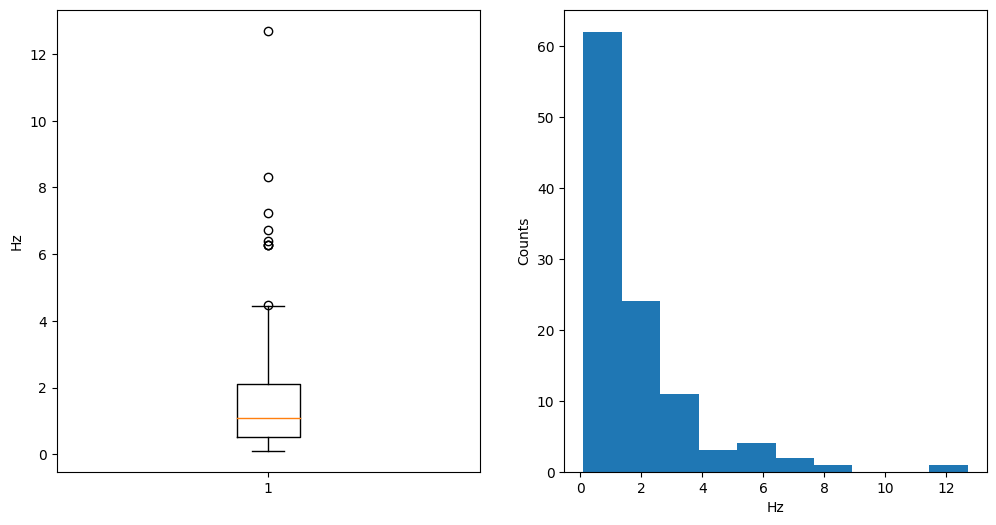

In [7]:
rates = [len(times)/rec_length for times in curated_spike_times]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
axs[0].boxplot(rates, showfliers=True)
axs[0].set_ylabel("Hz")
axs[1].hist(rates)
axs[1].set_xlabel("Hz")
axs[1].set_ylabel("Counts")
plt.show()


In [8]:
def plot_inset(axs, k, ch, position, temp_chs, temp_pos, templates, filename, nelec=2):
    # fig, axs = plt.subplots(figsize=(16, 9), facecolor='white')
    axs.set_title("{}".format(filename) + " cluster {} ".format(k) + "channel {} ".format(str(ch) + str(position)))
    assert len(temp_chs) == len(temp_pos) == len(templates), "Input length should be the same!"
    nums = len(temp_chs)
    pitch = 17.5
    axs.scatter(position[0], position[1], linewidth=10, alpha=0.2, color='grey')
    axs.text(position[0], position[1], str(position), color="g", fontsize=12)
    # set same scaling to the insets
    index = list(temp_chs).index(ch)
    ylim_min = min(templates[index])
    ylim_max = max(templates[index])
    # ylim_margin = (ylim_max - ylim_min)/10
    ylim_margin = 0
    # choose channels that are close to the center channel
    for i in range(nums):
        chn_pos = temp_pos[i]
        if position[0] - nelec * pitch <= chn_pos[0] <= position[0] + nelec * pitch \
                and position[1] - nelec * pitch <= chn_pos[1] <= position[1] + nelec * pitch:
            # axs.scatter(chn_pos[0], chn_pos[1], color='w')
            axin = axs.inset_axes([chn_pos[0]-5, chn_pos[1]-5, 10, 10], transform=axs.transData)
            axin.plot(templates[i], color='k', linewidth=2, alpha=0.7)
            axin.set_ylim([ylim_min - ylim_margin, ylim_max + ylim_margin])
            axin.set_axis_off()
    # axs.legend(loc="upper right", fontsize=12)
    # axs.xaxis.set_visible(False)
    # axs.yaxis.set_visible(False)
    axs.set_xlim(position[0]-2*nelec*pitch, position[0]+2*nelec*pitch)
    axs.set_ylim(position[1]-2*nelec*pitch, position[1]+2*nelec*pitch)
    axs.invert_yaxis()
    return axs

In [9]:
def get_data_dict(neuron_dict, key):
    ch = neuron_dict[key]['channel']
    pos = neuron_dict[key]['position']
    temp_chs = neuron_dict[key]['neighbor_channels']
    temp_pos = neuron_dict[key]['neighbor_positions']
    templates = neuron_dict[key]['neighbor_templates']
    return ch, pos, temp_chs, temp_pos, templates

In [12]:
def plot_footprint_with_isi(neuron_dict, spike_times, num_figure, figure_name):
    for i in range(num_figure): 
        k = list(neuron_dict.keys())[i]
        ch, pos, temp_chs, temp_pos, templates = get_data_dict(neuron_dict, k)
        
        isi = np.diff(spike_times[k])
        ref_isi = isi[isi < 5]   # just plot isi < 5 ms

        fig, axs = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[2, 1], facecolor='white')
        plot_inset(axs[0], k, ch, pos, temp_chs, temp_pos, templates, figure_name)
        # plot isi 
        axs[1].hist(isi, bins=int(max(isi)))
        axs[1].set_title("ISI Distribution", fontsize=16)
        axs[1].set_xlabel("ms", fontsize=16)
        axs[1].set_xlim(0, 5)


In [ ]:
# num_figure should be smaller than the total number of curated units 
plot_footprint_with_isi(curated_neuron_dict, curated_spike_times, 3, file_name)